In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
np.random.seed(1337)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Using TensorFlow backend.


# Data Loading and Analysis

In [2]:
train_data = pd.read_csv('C:/Users/hp/Documents/Python Projects/train.tsv', sep = '\t')
test_data = pd.read_csv('C:/Users/hp/Documents/Python Projects/test.tsv', sep = '\t')

In [41]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_words
0,1,1,series escapade demonstrate adage good goose a...,1,neutral
1,2,1,series escapade demonstrate adage good goose,2,somewhat negative
2,3,1,series,2,somewhat negative
4,5,1,series,2,somewhat negative
5,6,1,escapade demonstrate adage good goose,2,somewhat negative


In [42]:
test_data.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,intermittently please mostly routine effort
1,156062,8545,intermittently please mostly routine effort
3,156064,8545,intermittently please mostly routine effort
4,156065,8545,intermittently please mostly routine
5,156066,8545,intermittently please


In [43]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154741 entries, 0 to 156059
Data columns (total 5 columns):
PhraseId           154741 non-null int64
SentenceId         154741 non-null int64
Phrase             154741 non-null object
Sentiment          154741 non-null int64
Sentiment_words    154741 non-null object
dtypes: int64(3), object(2)
memory usage: 7.1+ MB


In [44]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65595 entries, 0 to 66291
Data columns (total 3 columns):
PhraseId      65595 non-null int64
SentenceId    65595 non-null int64
Phrase        65595 non-null object
dtypes: int64(2), object(1)
memory usage: 2.0+ MB


In [45]:
Sentiment_words = []
for row in train_data['Sentiment']:
    if row == 0:
        Sentiment_words.append('negative')
    elif row == 1:
        Sentiment_words.append('somewhat negative')
    elif row == 2:
        Sentiment_words.append('neutral')
    elif row == 3:
        Sentiment_words.append('somewhat positive')
    elif row == 4:
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
        
train_data['Sentiment_words'] = Sentiment_words

In [46]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_words
0,1,1,series escapade demonstrate adage good goose a...,1,somewhat negative
1,2,1,series escapade demonstrate adage good goose,2,neutral
2,3,1,series,2,neutral
4,5,1,series,2,neutral
5,6,1,escapade demonstrate adage good goose,2,neutral


In [47]:
word_count = pd.value_counts(train_data['Sentiment_words'].values)
word_count

neutral              78348
somewhat positive    32860
somewhat negative    27255
positive              9206
negative              7072
dtype: int64

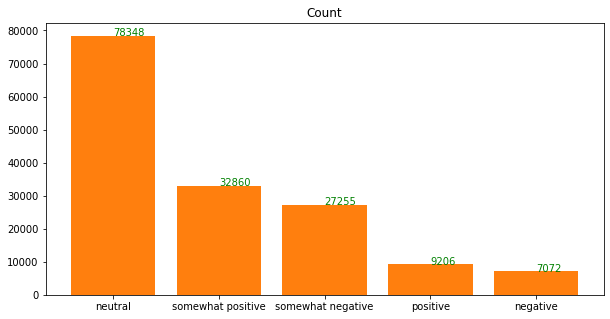

In [48]:
Idx = [1, 2, 3, 4, 5]
plt.figure(figsize = (10,5))
plt.bar(Idx, word_count)
plt.xticks(Idx, ['neutral','somewhat positive','somewhat negative','positive','negative'])
plt.title('Count')
plt.bar(Idx, word_count)
for a,b in zip(Idx, word_count):
    plt.text(a, b, str(b), color = 'green')

# DataPre-Processing

In [49]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')
pstemmer = PorterStemmer()

In [50]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [51]:
def text_processing(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = re.sub("[^a-zA-Z]"," ", text)
    words = text.split()
    stops = list(stopwords.words("english"))
    stops.remove('no')
    stops.remove('not')
    stops.remove('nor')
    words = [w for w in words if not w in set(stops)]
    #words = [stemmer.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return (' '.join(words))

In [14]:
train_data.Phrase = train_data.Phrase.apply(lambda x: text_processing(x))
test_data.Phrase = test_data.Phrase.apply(lambda x: text_processing(x))

In [15]:
train_data = train_data[train_data['Phrase'] != '']
test_data = test_data[test_data['Phrase'] != '']

In [16]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_words
0,1,1,series escapade demonstrate adage good goose a...,1,neutral
1,2,1,series escapade demonstrate adage good goose,2,somewhat negative
2,3,1,series,2,somewhat negative
4,5,1,series,2,somewhat negative
5,6,1,escapade demonstrate adage good goose,2,somewhat negative


In [17]:
train_data.to_csv("New_train.tsv")
test_data.to_csv("New_test.tsv")

# Data Visualization with wordclould

In [18]:
words = ' '.join(train_data['Phrase'])
words = ' '.join([word for word in words.split()])

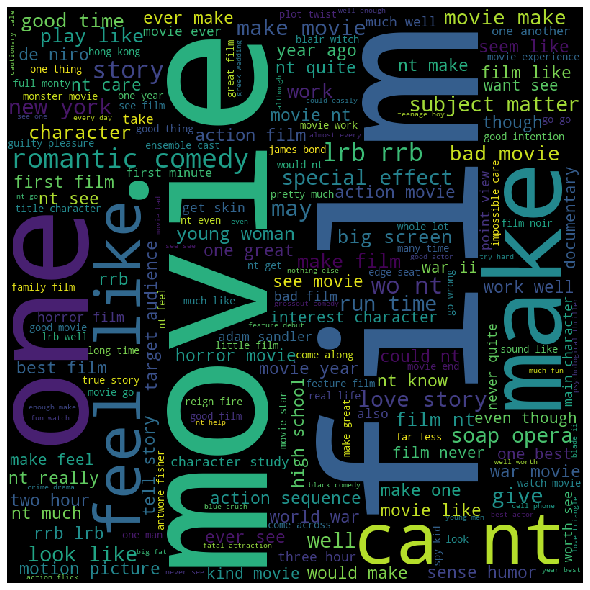

In [19]:
stops = set(stopwords.words("english"))

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stops, 
                min_font_size = 10).generate(words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

# Training

In [20]:
vocab_size = 10000
max_len = 125

data = list(train_data.Phrase)
data.append(list(test_data.Phrase))
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data)

def tokenize_data(data):
    data = tokenizer.texts_to_sequences(data)
    data = pad_sequences(data, maxlen=max_len)
    return data

In [21]:
def format_data(training_data, test_data, vocab_size, max_len):
    train_X = training_data['Phrase']
    train_Y = to_categorical(training_data['Sentiment'].values)
    test_X = test_data['Phrase']

    train_X = tokenize_data(train_X)
    test_X = tokenize_data(test_X)
    return train_X, train_Y, test_X

In [22]:
train_X, train_Y, test_X = format_data(train_data, test_data, vocab_size, max_len)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.25)

In [23]:
model = Sequential()
model.add(Embedding(vocab_size, 100, mask_zero=True))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 1,085,125
Trainable params: 1,085,125
Non-trainable params: 0
_________________________________________________________________


In [26]:
epochs = 5
batch_size = 128

weight_filepath = 'weights.hdf5'
checkpoint = ModelCheckpoint(
    weight_filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=callbacks_list)

model.load_weights(weight_filepath)

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 116055 samples, validate on 38686 samples
Epoch 1/5
116055/116055 [==============================] - 1570s 14ms/step - loss: 0.6161 - accuracy: 0.7437 - val_loss: 0.9201 - val_accuracy: 0.6467
Epoch 2/5
116055/116055 [==============================] - 1719s 15ms/step - loss: 0.5851 - accuracy: 0.7538 - val_loss: 0.9535 - val_accuracy: 0.6463
Epoch 3/5
112640/116055 [============================>.] - ETA: 50s - loss: 0.5585 - accuracy: 0.7604

KeyboardInterrupt: 

In [28]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [30]:
print(test_X.shape)
weight_filepath1 = 'weights.hdf5'
model.load_weights(weight_filepath1)
review = "the movie was not bad"
processed_review = [text_processing(review)]
tokenized_review = tokenize_data(processed_review[0:1])
sentiment = model.predict_classes(tokenized_review)
print(sentiment)

(65595, 125)
[2]
